# <font color=yellow>Football League Generator</font>
## Procedural Programming Version

In this version of the football league generator inspired by Paul Kelly's video https://youtu.be/JcVpyIFxUDw. This is the initial notebook in which I have worked out the functionality in a "spaghetti code" style before I rewrote it all in OOP style.

Requires the following libraries to be installed on your local machine: 
* https://pypi.org/project/pandas/
* https://pypi.org/project/xlwings/
* https://pypi.org/project/ipywidgets/


In [1]:
import copy
import random
import pandas as pd
import numpy as np
import ipywidgets as widget
import matplotlib.pyplot as plt

# Teams and Match Schedules
Manually enter your league's names here:

In [2]:
addedDummy = False

teams = ['Arsenal', 'Brentford', 'Chelsea', 'Everton', 'Fulham', 'Wolves', 
         'Liverpool', 'Tottenham', 'ManCity', 'ManUtd', 'AstonVilla', 'Blackburn',
        'QPR', 'Reading', 'WestHam', 'Sunderland', 'Southampton', 'Stoke', 'Leicester', 'Leeds']
original_teams = copy.deepcopy(teams)

if len(teams) % 2 != 0:
    teams.append('_dummy')
    addedDummy = True

# Shuffle the shift_teams list initially, otherwise list in the order that it was
# initally input (usally alphabetically and it doesn't look random enough)
    
shift_teams = copy.deepcopy(teams)
random.shuffle(shift_teams)

# print(teams)
# print(shift_teams)

The following is the logic / functionality to "rotate" through the teams list.
We mainly want to keep first team fixed while circulating the other teams.

In [3]:
def circ_shift(my_teams):
    first_team = my_teams.pop(0)
    my_teams.append(first_team)

In [4]:
def circ_shift_fix_first(my_teams):
    second_team = my_teams.pop(1)
    my_teams.append(second_team)

In [5]:
def create_event(my_teams):
    L = len(my_teams)
    H = int(L/2)
    return [[my_teams[i], my_teams[(L-1)-i]] for i in range(H) if '_dummy' not in [my_teams[i], my_teams[(L-1)-i]]]

In [6]:
def print_schedule(schedule):
    for event in schedule:
        for match in event:
            print(f"{match[0]} vs {match[1]}")

In [7]:
schedule = []
for _ in range(len(teams) - 1):
    event = create_event(shift_teams)
    schedule.append(event)
    circ_shift_fix_first(shift_teams)

# print(schedule)
# print_schedule(schedule)

We usually have to Home and Away legs of the competition. This is why we mirror first schedule, and swap the home and away teams around.

In [8]:
def mirror_list(schedule):
    mirror_sched = []
    for event in schedule:
        mirror_event = []
        for match in event:
            mirror_event.append([match[1], match[0]])
        mirror_sched.append(mirror_event)      
    return mirror_sched

In [9]:
mirror = mirror_list(schedule)
# print_schedule(mirror)

In [10]:
# full_schedule = schedule + mirror
full_schedule = [*schedule, *mirror]
# print_schedule(full_schedule)

Flatten the schedule to a 2d list, as the full schedule is a list within a list with a list. This is so that we can populate a pandas dataframe to anlayze the schedule easier.

In [11]:
def flatten_schedule(schedule):
    event_num = 0
    match_num = 0
    flat_sched = []
    for event in schedule:
        event_num += 1
        for match in event:
            match_num += 1
            flat_sched.append([event_num, match_num, *match])
    return flat_sched


In [12]:
# next flatten schedule to 2d list, and convert schedule to dataframe
flat_schedule = flatten_schedule(full_schedule)
# print(flat_schedule)

# Keep Score

You can either simulate scores using the provided random score generator functionallity or enter results manually.

In [13]:
headers = ['event', 'match', 'host_team', 'guest_team']
df_matches = pd.DataFrame(flat_schedule, columns=headers)

df_matches['host_score'] = None # '' # np.nan
# df_matches['host_score'].astype('int8')

df_matches['guest_score'] = None # '' # np.nan
# df_matches['guest_score'].astype('int8')

# df_matches.head()

In [14]:
def keep_score(df, match, host_score, guest_score):
    try:
        df.loc[df["match"] == match, ["host_score", "guest_score"]] = [int(host_score), int(guest_score)]
    except Exception as e:
        print(e)

## Simulate random scores

In [15]:
def random_score():
    return int(random.random() * random.randint(0, 11))

In [16]:
# randomize league results
for match in range(1, df_matches.shape[0] + 1):
    keep_score(df_matches, match, random_score(), random_score())

In [17]:
print(df_matches)

     event  match   host_team   guest_team host_score guest_score
0        1      1   Liverpool      Arsenal          0           0
1        1      2   Blackburn      Everton          1           3
2        1      3   Leicester       ManUtd          5           2
3        1      4       Leeds       Wolves          8           0
4        1      5     ManCity  Southampton          3           1
..     ...    ...         ...          ...        ...         ...
375     38    376  AstonVilla      ManCity          2           1
376     38    377     Reading    Tottenham          2           0
377     38    378         QPR      WestHam          3           0
378     38    379      Fulham        Stoke          7           3
379     38    380   Brentford      Chelsea          0           3

[380 rows x 6 columns]


### Other methods of inputing data

* Input via this notebook using the input() built-in function, which is the slow way
* Using xlwings API to read and write between Excel (my preferred choice)
* Using openpyxl library to read and write
* Or pandas.read_excel(), pandas.read_csv(), etc.


In [18]:
# Input scores manually. Coming soon...


# League table

Putting the league table in a pandas DataFrame as it is easier to analyze.

In [19]:
# Initialize table
df_league = pd.DataFrame(sorted(original_teams), columns=['Team'])
df_league['MP'] = 0
df_league['W'] = 0
df_league['D'] = 0
df_league['L'] = 0
df_league['GF'] = 0
df_league['GA'] = 0
df_league['GD'] = 0
df_league['Pts'] = 0

# df_league_reset = copy.deepcopy(df_league)

In [20]:
def reset_table(df_league):
    for col in range(1, len(df_league.columns)):
        df_league.iloc[:, col] = 0

In [21]:
def update_table(df_league, df_matches):
    reset_table(df_league) # NB
    
    for i in range(df_matches.shape[0]):
        if not all(score is None for score in df_matches.loc[i, ["host_score", "guest_score"]]):
            host_team = str(df_matches.at[i, "host_team"])
            host_score = int(df_matches.at[i, "host_score"])
            guest_team = str(df_matches.at[i, "guest_team"])
            guest_score = int(df_matches.at[i, "guest_score"])
            
            host_id = int(df_league.loc[df_league['Team'] == host_team].index.values[0])
            guest_id = int(df_league.loc[df_league['Team'] == guest_team].index.values[0])
                        
            df_league.at[host_id, 'MP'] += 1
            df_league.at[guest_id, 'MP'] += 1
            
            df_league.at[host_id, 'GF'] += host_score
            df_league.at[host_id, 'GA'] += guest_score
            df_league.at[host_id, 'GD'] += host_score - guest_score
            
            df_league.at[guest_id, 'GF'] += guest_score
            df_league.at[guest_id, 'GA'] += host_score
            df_league.at[guest_id, 'GD'] += guest_score - host_score 
            
            if host_score > guest_score:
                df_league.at[host_id, 'W'] += 1
                df_league.at[guest_id, 'L'] += 1
                df_league.at[host_id, 'Pts'] += 3
            elif host_score < guest_score:
                df_league.at[guest_id, 'W'] += 1
                df_league.at[host_id, 'L'] += 1
                df_league.at[guest_id, 'Pts'] += 3
            else:
                df_league.at[host_id, 'D'] += 1
                df_league.at[guest_id, 'D'] += 1
                df_league.at[host_id, 'Pts'] += 1
                df_league.at[guest_id, 'Pts'] += 1


In [22]:
update_table(df_league, df_matches)

In [23]:
def sort_table(df_league):
    df_league.sort_values(by=['Pts', 'GD', 'W', 'D', 'GF', 'GA'], 
                          ascending=[False, False, False, False, False, False], 
                          inplace=True)
    df_league.reset_index(drop=True, 
                          inplace=True)


In [24]:
sort_table(df_league)
df_league

,Team,MP,W,D,L,GF,GA,GD,Pts
0,Reading,38,20,8,10,100,61,39,68
1,Brentford,38,18,7,13,97,72,25,61
2,QPR,38,18,7,13,82,69,13,61
3,Tottenham,38,17,9,12,81,54,27,60
4,Leicester,38,17,9,12,104,91,13,60
5,WestHam,38,17,9,12,84,71,13,60
6,Southampton,38,19,2,17,103,76,27,59
7,Sunderland,38,17,6,15,86,70,16,57
8,AstonVilla,38,16,8,14,83,75,8,56
9,Leeds,38,16,5,17,93,99,-6,53


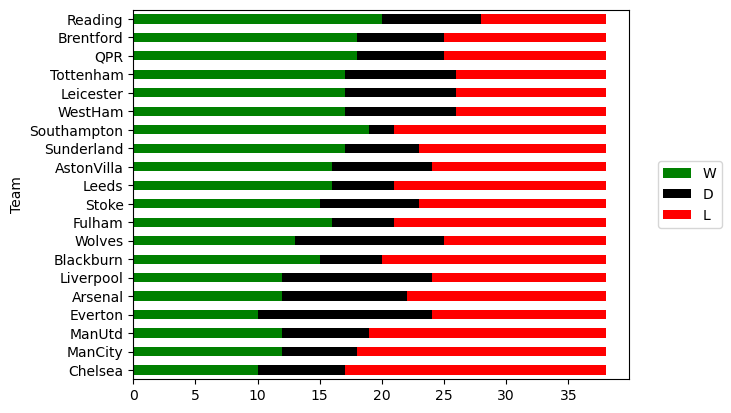

In [25]:
ax = df_league.plot.barh(x="Team", y=["W", "D", "L"], stacked=True, color=["g", "k", "r"], rot=0)
ax.legend(loc="center right", bbox_to_anchor=(1.2, 0.5))
ax.invert_yaxis()
plt.show()

# Filter matches on a team

Requires installation on local machine: https://pypi.org/project/ipywidgets/

```pip install ipywidgets```

In [26]:
def color_result(val):
    return f'background-color: red;' if val < 0 else f'background-color: green;' if val > 0 else None

In [27]:
def get_filtered_team_matches(filter_on_team, df_matches):
    filter_mask = (df_matches['host_team'] == filter_on_team) | (df_matches['guest_team'] == filter_on_team)
    filtered_matches = copy.deepcopy(df_matches.loc[filter_mask])
    filtered_matches.reset_index(drop=True, inplace=True)
    new_col = filter_on_team + '_WDL'
    filtered_matches[new_col] = None

    for m in range(filtered_matches.shape[0]):
        if filtered_matches.at[m, 'host_team'] == filter_on_team:
            score1, score2 = 'host_score', 'guest_score'
        else:
            score1, score2  = 'guest_score', 'host_score'

        if filtered_matches.at[m, score1] > filtered_matches.at[m, score2]:
            filtered_matches.at[m, new_col] = 1 # Win
        elif filtered_matches.at[m, score1] == filtered_matches.at[m, score2]:
            filtered_matches.at[m, new_col] = 0 # Draw
        else:
            filtered_matches.at[m, new_col] = -1 # Loss
    
    return filtered_matches

In [28]:
# dropdown list
dd_widget = widget.Dropdown(options=sorted(original_teams), description='Select team:')



In [29]:
dd_widget

Dropdown(description='Select team:', options=('Arsenal', 'AstonVilla', 'Blackburn', 'Brentford', 'Chelsea', 'E…

In [30]:
selected_team = str(dd_widget.value)
print(f"You have selected: {selected_team}")

You have selected: Arsenal


## Wins, Draws and Losses 

Wins, draws and losses history for the selected team.

In [31]:
filtered_matches = get_filtered_team_matches(selected_team, df_matches)
filtered_matches.style.applymap(color_result, subset=[selected_team + '_WDL']) 

,event,match,host_team,guest_team,host_score,guest_score,Arsenal_WDL
0,1,1,Liverpool,Arsenal,0,0,0
1,2,12,Leicester,Arsenal,3,3,0
2,3,23,ManCity,Arsenal,1,0,-1
3,4,34,WestHam,Arsenal,4,0,-1
4,5,45,Chelsea,Arsenal,0,8,1
5,6,56,Fulham,Arsenal,0,5,1
6,7,67,Reading,Arsenal,6,7,1
7,8,78,Sunderland,Arsenal,1,9,1
8,9,89,Wolves,Arsenal,2,1,-1
9,10,100,Everton,Arsenal,2,2,0


## Goals Analysis

Analysis of goals scored for and agains the selected team.

In [32]:
# Get GF and GA for selected team:
goals_for = [] # goals scores by the selected team
goals_against = [] # goals conceeded by the selected team

for row in range(filtered_matches.shape[0]):
    # print(filtered_matches.iloc[row,])
    if filtered_matches.at[row, 'host_team'] == selected_team:
        goals_for.append(filtered_matches.at[row, 'host_score'])
        goals_against.append(filtered_matches.at[row, 'guest_score'])
    else:
        goals_for.append(filtered_matches.at[row, 'guest_score'])
        goals_against.append(filtered_matches.at[row, 'host_score'])

print(f"You have selected: {selected_team}")
print('GF', goals_for)
print('GA', goals_against)

You have selected: Arsenal
GF [0, 3, 0, 0, 8, 5, 7, 9, 1, 2, 8, 8, 5, 6, 0, 0, 0, 4, 3, 0, 0, 1, 7, 3, 0, 0, 2, 9, 1, 0, 7, 0, 0, 0, 4, 0, 0, 1]
GA [0, 3, 1, 4, 0, 0, 6, 1, 2, 2, 7, 0, 1, 6, 0, 6, 0, 0, 0, 4, 1, 1, 5, 4, 0, 4, 3, 0, 3, 2, 0, 4, 1, 9, 6, 0, 4, 1]


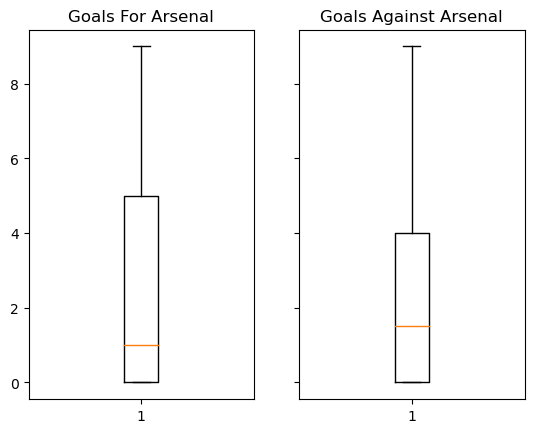

In [33]:
# Box-whisker plot: "Min", 25th perc, 50th perc (Median), 75 perc, "Max", outliers.
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True)
ax1.boxplot(goals_for)
ax1.set_title(f'Goals For {selected_team}')

ax2.boxplot(goals_against)
ax2.set_title(f'Goals Against {selected_team}')

plt.show()